In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Conv2D , GlobalAveragePooling2D,Input , Dense ,BatchNormalization , Dropout , AveragePooling2D,MaxPool2D
from tensorflow.keras.models import load_model , save_model , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint
from tensorflow.keras.optimizers import Adam , SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
folder_dir = 'C:/Users/varghese.jacob/Documents/Data Structures/flowers'

In [3]:
#Loading the files
data = []
label = []

SIZE = 96 #Crop the image to 80x80

for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

In [4]:
data=np.array(data)
label=np.array(label)

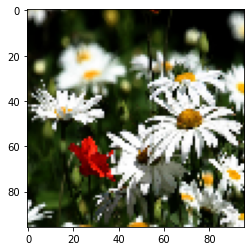

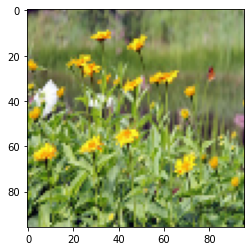

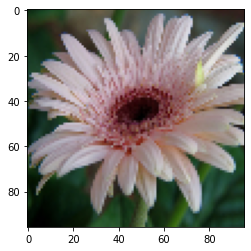

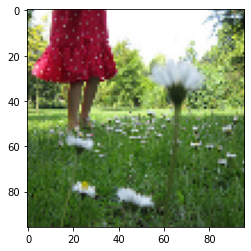

In [5]:
#Just few images
for i in range(0,4):
    plt.imshow(data[i])
    plt.show()

In [7]:
#Add noise to see how it tempered loss works

def add_gaussian_noise(images, mean=0, std=10):
    noisy_images = []
    for image in images:
        noise = np.random.normal(mean, std, image.shape)
        noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
        noisy_images.append(noisy_image)
    return np.array(noisy_images)


In [8]:
noisy_data = add_gaussian_noise(data)


In [9]:
#the labels should be converted
encode=LabelEncoder()
Y=encode.fit_transform(label)
Y=to_categorical(Y,5)

In [10]:
X=noisy_data
print(X.shape)
print(Y.shape)

(4312, 96, 96, 3)
(4312, 5)


In [11]:
#splitting the data
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=100,test_size=0.25)

In [12]:
#To prevent overfitting
datagen = ImageDataGenerator(
        rescale=1/255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           shear_range=0.2,
                           zoom_range=0.2,
                           fill_mode='nearest',
                           height_shift_range=0.2,
                           width_shift_range=0.2,
                           rotation_range=0.2
)

datagen.fit(xtrain)

In [13]:
def tempered_softmax(logits, t2):
    logits_t2 = logits / t2
    exp_logits_t2 = tf.exp(logits_t2)
    sum_exp_logits_t2 = tf.reduce_sum(exp_logits_t2, axis=-1, keepdims=True)
    tempered_probs = exp_logits_t2 / sum_exp_logits_t2
    return tempered_probs

def bi_tempered_logistic_loss(y_true, y_pred, t1, t2):
    tempered_probs = tempered_softmax(y_pred, t2)
    y_pred_t1 = tf.pow(tempered_probs, 1 - t1)
    y_true_t1 = tf.pow(y_true, 1 - t1)
    loss = tf.reduce_sum(y_true * (y_true_t1 - y_pred_t1) / (1 - t1), axis=-1)
    return tf.reduce_mean(loss)


In [14]:
from tensorflow.keras.applications import MobileNetV2

In [15]:
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model


In [16]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=lambda y_true, y_pred: bi_tempered_logistic_loss(y_true, y_pred, t1=0.8, t2=1.2), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)


history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=len(xtrain) // 32,
                    epochs=100,
                    validation_data=(xtest / 255, ytest),
                    callbacks=[early_stopping])



9406464/9406464 [==============================] - 13s 1us/step
Epoch 1/100
101/101 [==============================] - 52s 444ms/step - loss: 1.2441 - accuracy: 0.4872 - val_loss: 1.1360 - val_accuracy: 0.7013
Epoch 2/100
101/101 [==============================] - 43s 430ms/step - loss: 1.1247 - accuracy: 0.6836 - val_loss: 1.0834 - val_accuracy: 0.7672
Epoch 3/100
101/101 [==============================] - 43s 424ms/step - loss: 1.0905 - accuracy: 0.7355 - val_loss: 1.0651 - val_accuracy: 0.7894
Epoch 4/100
101/101 [==============================] - 43s 429ms/step - loss: 1.0805 - accuracy: 0.7452 - val_loss: 1.0592 - val_accuracy: 0.7931
Epoch 5/100
101/101 [==============================] - 44s 432ms/step - loss: 1.0698 - accuracy: 0.7608 - val_loss: 1.0511 - val_accuracy: 0.7987
Epoch 6/100
101/101 [==============================] - 43s 428ms/step - loss: 1.0612 - accuracy: 0.7758 - val_loss: 1.0441 - val_accuracy: 0.8135
Epoch 7/100
101/101 [==============================] - 44s 4

101/101 [==============================] - 18s 177ms/step - loss: 1.0011 - accuracy: 0.8670 - val_loss: 1.0238 - val_accuracy: 0.8321
Epoch 56/100
101/101 [==============================] - 18s 182ms/step - loss: 1.0004 - accuracy: 0.8641 - val_loss: 1.0271 - val_accuracy: 0.8228
Epoch 57/100
101/101 [==============================] - 19s 189ms/step - loss: 1.0002 - accuracy: 0.8670 - val_loss: 1.0235 - val_accuracy: 0.8321
Epoch 58/100
101/101 [==============================] - 22s 215ms/step - loss: 1.0007 - accuracy: 0.8701 - val_loss: 1.0211 - val_accuracy: 0.8321
Epoch 59/100
101/101 [==============================] - 24s 240ms/step - loss: 1.0010 - accuracy: 0.8670 - val_loss: 1.0211 - val_accuracy: 0.8340
Epoch 60/100
101/101 [==============================] - 22s 213ms/step - loss: 0.9969 - accuracy: 0.8720 - val_loss: 1.0225 - val_accuracy: 0.8312
Epoch 61/100
101/101 [==============================] - 21s 211ms/step - loss: 0.9999 - accuracy: 0.8641 - val_loss: 1.0237 - val_a

In [17]:
model.evaluate(xtest / 255, ytest)


34/34 [==============================] - 4s 122ms/step - loss: 1.0182 - accuracy: 0.8377


[1.0182374715805054, 0.8376623392105103]